# <p style="text-align:center;fontsize:35px">PHASE 02</p>

## <p style="fontsize:25px">Importing necessary libraries</p>

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from matplotlib import pyplot as plt
import seaborn as sns

## <p style="fontsize:25px">Classes for preprocessing and modelling</p>

In [11]:
class DataPreprocessing:
    def __init__(self,data):
        self.data = data
        from warnings import filterwarnings
        filterwarnings("ignore")
        self.objects=DataPreprocessing.initialize()
        self.input = None
        self.output = None
        self.features = list(data.columns)
        self.output_name = None
        self.train_features,self.train_target,self.test_target,self.test_features = None,None,None,None
    def drop_columns(self,columns):
        self.data.drop(columns,axis=1,inplace=True)
        if type(columns) == list:
            self.features = [i for i in self.features if i not in columns]
        else:
            self.features.remove(columns)
    def handle_null(self,type='drop'):
        if type=='drop':
            self.data.dropna(axis=0,inplace=True)
        if type=="mean":
            self.data=self.data.apply(lambda x:x.fillna(x.mean()))
    def initialize():
        from sklearn import preprocessing,model_selection,decomposition
        return {
                'Standard scaler':preprocessing.StandardScaler,
                'Min Max Scalar':preprocessing.MinMaxScaler,
                'PCA':decomposition.PCA,
                'train test split':model_selection.train_test_split,
               }
    def out_in(self,output_name):
        self.input = self.data.drop(output_name,axis=1)
        self.output = self.data[output_name]
        self.features.remove(output_name)
        self.output_name = output_name
    def apply_count_vectorize(self,col,count_vect_obj=None):
        if count_vect_obj ==None:
            from sklearn.feature_extraction.text import CountVectorizer
            self.objects['Countvec_'+col] = CountVectorizer()
            self.data[col] = self.objects['Countvec_'+col].fit_transform(self.data[col])
        else:
            self.objects['Countvec_'+col] = count_vect_obj
            self.data[col] = self.objects['Countvec_'+col].fit_transform(self.data[col])
    def split(self,test_percent,rs = 42):
         self.train_features,self.test_features,self.train_target,self.test_target = self.objects['train test split'](self.input,self.output,test_size=test_percent,random_state=rs)
    def get_object_column(self):
        import numpy as np
        edit_col = [i for i in self.features if self.data[i].dtype == np.object_]
        return edit_col
    def encode_categorical_columns(self):
        import numpy as np
        from sklearn.preprocessing import LabelEncoder
        label_encoder_objects ={}
        edit_columns = self.get_object_column()
        for col in edit_columns:
            label_object = LabelEncoder()
            self.data[col]=label_object.fit_transform(self.data[col])
            label_encoder_objects[col+"_encoder_object"] = label_object
        self.objects['Label_Encoder'] = label_encoder_objects
    def change_columns(self,columns):
        self.data = self.data[columns]
    def apply_smote_data(self):
        from imblearn.over_sampling import SMOTE
        smote_object = SMOTE()
        self.train_features,self.train_target = smote_object.fit_resample(self.train_features,self.train_target)
        self.objects['Smote object'] = smote_object
    def standardize_or_normalize(self,scale_type=None):
        if scale_type == "Standard":
            from pandas import DataFrame as df
            scale_object  = self.objects['Standard scaler']()
            self.train_features=df(data = scale_object.fit_transform(self.train_features),columns = self.features)
            self.test_features = df(data = scale_object.fit_transform(self.test_features),columns = self.features)
        elif scale_type == "Normalize":
            from pandas import DataFrame as df
            scale_object  = self.objects['Min Max Scalar']()
            self.train_features=df(data = scale_object.fit_transform(self.train_features),columns = self.features)
            self.test_features = df(data = scale_object.fit_transform(self.test_features),columns = self.features)

In [12]:
class MacineLearningClassification:
    def __init__(self,data_pr,prediction_array=None,k_fold_num=None,models=None):
        self.best_accuracy = 0
        self.prediction_array=prediction_array
        self.best_model = None
        self.best_model_object = None
        self.data = data_pr.data
        self.train_features = data_pr.train_features
        self.train_target = data_pr.train_target
        self.test_features = data_pr.test_features
        self.test_target = data_pr.test_target
        if models==None:
            from sklearn.linear_model import LogisticRegression
            from sklearn.tree import DecisionTreeClassifier
            from sklearn.ensemble import RandomForestClassifier
            from sklearn.naive_bayes import BernoulliNB,GaussianNB
            from sklearn.neighbors import KNeighborsClassifier
            models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),BernoulliNB(),GaussianNB(),KNeighborsClassifier()]
        self.model_evaluvation_dict = {str(i).replace("()",""):{'model_object':i} for i in models}
        self.model_prediction = {str(i).replace("()",""):None for i in models}
    def fit(self):
        for model,dic in self.model_evaluvation_dict.items():
            self.model_evaluvation_dict[model]['model_object'].fit(self.train_features,self.train_target)
            self.model_prediction[model] = self.model_evaluvation_dict[model]['model_object'].predict(self.test_features)
    def Score_test_data(self):
        for model,dic in self.model_evaluvation_dict.items():
            self.model_evaluvation_dict[model]['score on test data'] = self.model_evaluvation_dict[model]['model_object'].score(self.test_features,self.test_target)*100
            if (self.model_evaluvation_dict[model]['score on test data']>self.best_accuracy):
                self.best_model = {'Model_obj':self.model_evaluvation_dict[model]['model_object'],
                                   'Name':model,
                                  'Accuracy':self.model_evaluvation_dict[model]['score on test data']}
                self.best_accuracy = self.model_evaluvation_dict[model]['score on test data']
    def create_confusion_matrix(self):
        from sklearn.metrics import confusion_matrix
        for model,dic in self.model_evaluvation_dict.items():
            self.model_evaluvation_dict[model]['confusion matrix for test data'] = confusion_matrix(self.test_target,self.model_prediction[model]).tolist()
    def create_f1_precision_recall(self):
        from sklearn.metrics import f1_score,recall_score,precision_score
        for model,dic in self.model_evaluvation_dict.items():
            self.model_evaluvation_dict[model]['f1 score for test data'] = f1_score(self.test_target,self.model_prediction[model],average='macro')*100
            self.model_evaluvation_dict[model]['precision for test data'] = precision_score(self.test_target,self.model_prediction[model],average='macro')*100
            self.model_evaluvation_dict[model]['recall for test data'] = recall_score(self.test_target,self.model_prediction[model],average='macro')*100
    def evaluvate(self):
        import numpy as np
        self.fit()
        self.Score_test_data()
        self.create_confusion_matrix()
        self.create_f1_precision_recall()
        if type(self.prediction_array)==np.ndarray:
            self.model_evaluvation_dict['prediction']=self.best_model['Model_obj'].predict(np.array([self.prediction_array]))[0]
        for model in self.model_evaluvation_dict:
            if model!='prediction':
                del self.model_evaluvation_dict[model]['model_object']
        self.best_model_object = self.best_model['Model_obj']
        del self.best_model['Model_obj']
        self.model_evaluvation_dict['best model'] = self.best_model
        return self.model_evaluvation_dict

In [118]:
class MachineLearningRegression:
    def __init__(self,data_pr,prediction_array=None,k_fold_num=None,models=None):
        self.best_r2_score = 0
        self.best_model = None
        self.best_model_object = None
        self.prediction_array=prediction_array
        self.data = data_pr.data
        self.train_features = data_pr.train_features
        self.train_target = data_pr.train_target
        self.test_features = data_pr.test_features
        self.test_target = data_pr.test_target
        if models == None:
            from sklearn.linear_model import LinearRegression,Ridge,Lasso
            from sklearn.tree import DecisionTreeRegressor
            from sklearn.ensemble import RandomForestRegressor
            from sklearn.neighbors import KNeighborsRegressor
            models = [LinearRegression(),Ridge(),Lasso(),DecisionTreeRegressor(),RandomForestRegressor(),KNeighborsRegressor()]
        self.model_evaluvation_dict = {str(i).replace("()",""):{'model_object':i} for i in models}
        self.model_prediction = {str(i).replace("()",""):None for i in models}
    def fit(self):
        for model,dic in self.model_evaluvation_dict.items():
            self.model_evaluvation_dict[model]['model_object'].fit(self.train_features,self.train_target)
            self.model_prediction[model] = self.model_evaluvation_dict[model]['model_object'].predict(self.test_features)
    def Score_test_dataset(self):
        from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
        metrics = {'r2 score':r2_score,'MAE':mean_absolute_error,'MSE':mean_squared_error,'MAPE':mean_absolute_percentage_error}
        for model,dic in self.model_evaluvation_dict.items():
            for metric,obj in metrics.items():
                self.model_evaluvation_dict[model][metric] = obj(self.model_prediction[model],self.test_target)
                if self.model_evaluvation_dict[model]['r2 score']>self.best_r2_score:
                    self.best_model = {'Name':model,
                                       'r2 score':self.model_evaluvation_dict[model]['r2 score'],
                                        'model_obj':self.model_evaluvation_dict[model]['model_object']}
                    self.best_r2_score = self.model_evaluvation_dict[model]['r2 score']
    def evaluvate(self):
        import numpy as np
        self.fit()
        self.Score_test_dataset()
        if type(self.prediction_array)==np.ndarray:
            self.model_evaluvation_dict['prediction']=self.best_model['model_obj'].predict(np.array([self.prediction_array]))[0]
        for model in self.model_evaluvation_dict:
            if model!='prediction':
                del self.model_evaluvation_dict[model]['model_object']
        self.best_model_object = self.best_model['model_obj']
        del self.best_model['model_obj']
        self.model_evaluvation_dict['best model'] = self.best_model
        return self.model_evaluvation_dict

## <p style="fontsize:25px"> Dataset 1 </p>

#### <p style="fontsize:15px"> Relative Humidity prediction  </p>

#### READING THE DATASET

In [104]:
dataset = pd.read_csv("Datasets/AirQualityUCI.csv")

#### DATA CLEANING AND ANALYSIS

##### We aggregate the data by week, because it will give a smoother trend to analyze.

In [105]:
dataset.drop(['Unnamed: 15','Unnamed: 16','Date','Time'],axis=1,inplace=True)

In [106]:
data_p_object = DataPreprocessing(dataset)
data_p_object.data.head(5)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [107]:
data_p_object.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9357 non-null   float64
 1   PT08.S1(CO)    9357 non-null   float64
 2   NMHC(GT)       9357 non-null   float64
 3   C6H6(GT)       9357 non-null   float64
 4   PT08.S2(NMHC)  9357 non-null   float64
 5   NOx(GT)        9357 non-null   float64
 6   PT08.S3(NOx)   9357 non-null   float64
 7   NO2(GT)        9357 non-null   float64
 8   PT08.S4(NO2)   9357 non-null   float64
 9   PT08.S5(O3)    9357 non-null   float64
 10  T              9357 non-null   float64
 11  RH             9357 non-null   float64
 12  AH             9357 non-null   float64
dtypes: float64(13)
memory usage: 962.0 KB


In [108]:
data_p_object.data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [109]:
data_p_object.handle_null('mean')

In [110]:
data_p_object.data.isnull().any()

CO(GT)           False
PT08.S1(CO)      False
NMHC(GT)         False
C6H6(GT)         False
PT08.S2(NMHC)    False
NOx(GT)          False
PT08.S3(NOx)     False
NO2(GT)          False
PT08.S4(NO2)     False
PT08.S5(O3)      False
T                False
RH               False
AH               False
dtype: bool

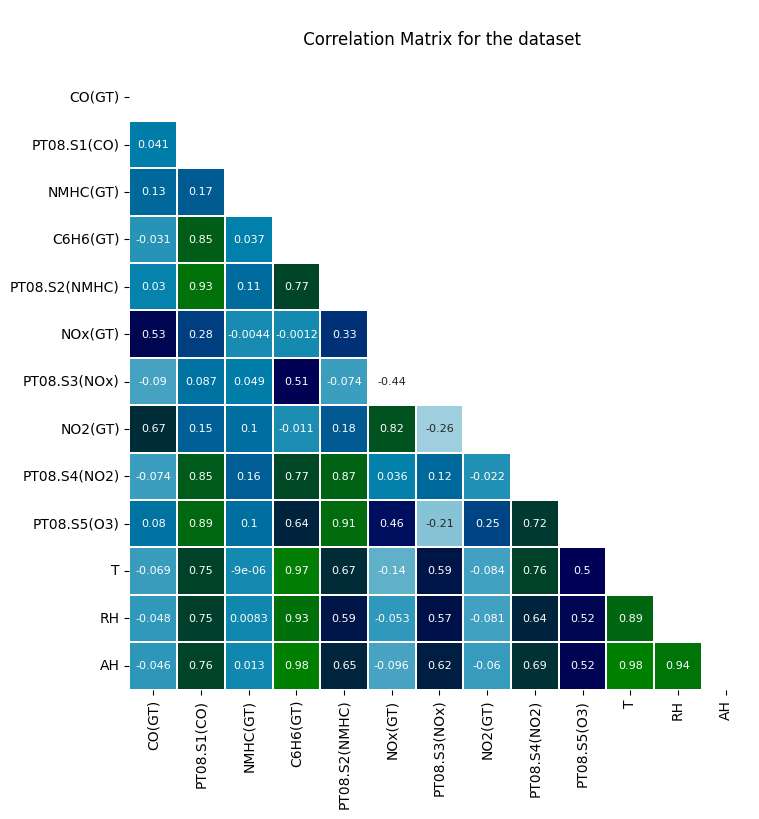

In [111]:
corr = data_p_object.data.corr()
mask = np.ones_like(corr,dtype=np.bool_)
mask[np.tril_indices_from(mask)]=False
mask[np.diag_indices_from(mask)]=True
fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
sns.heatmap(corr,annot=True,mask=mask,ax=axes,linewidths=0.2,annot_kws={'fontsize':8},cbar=False,cmap='ocean_r')
axes.set_title('\n Correlation Matrix for the dataset\n')
fig.show()

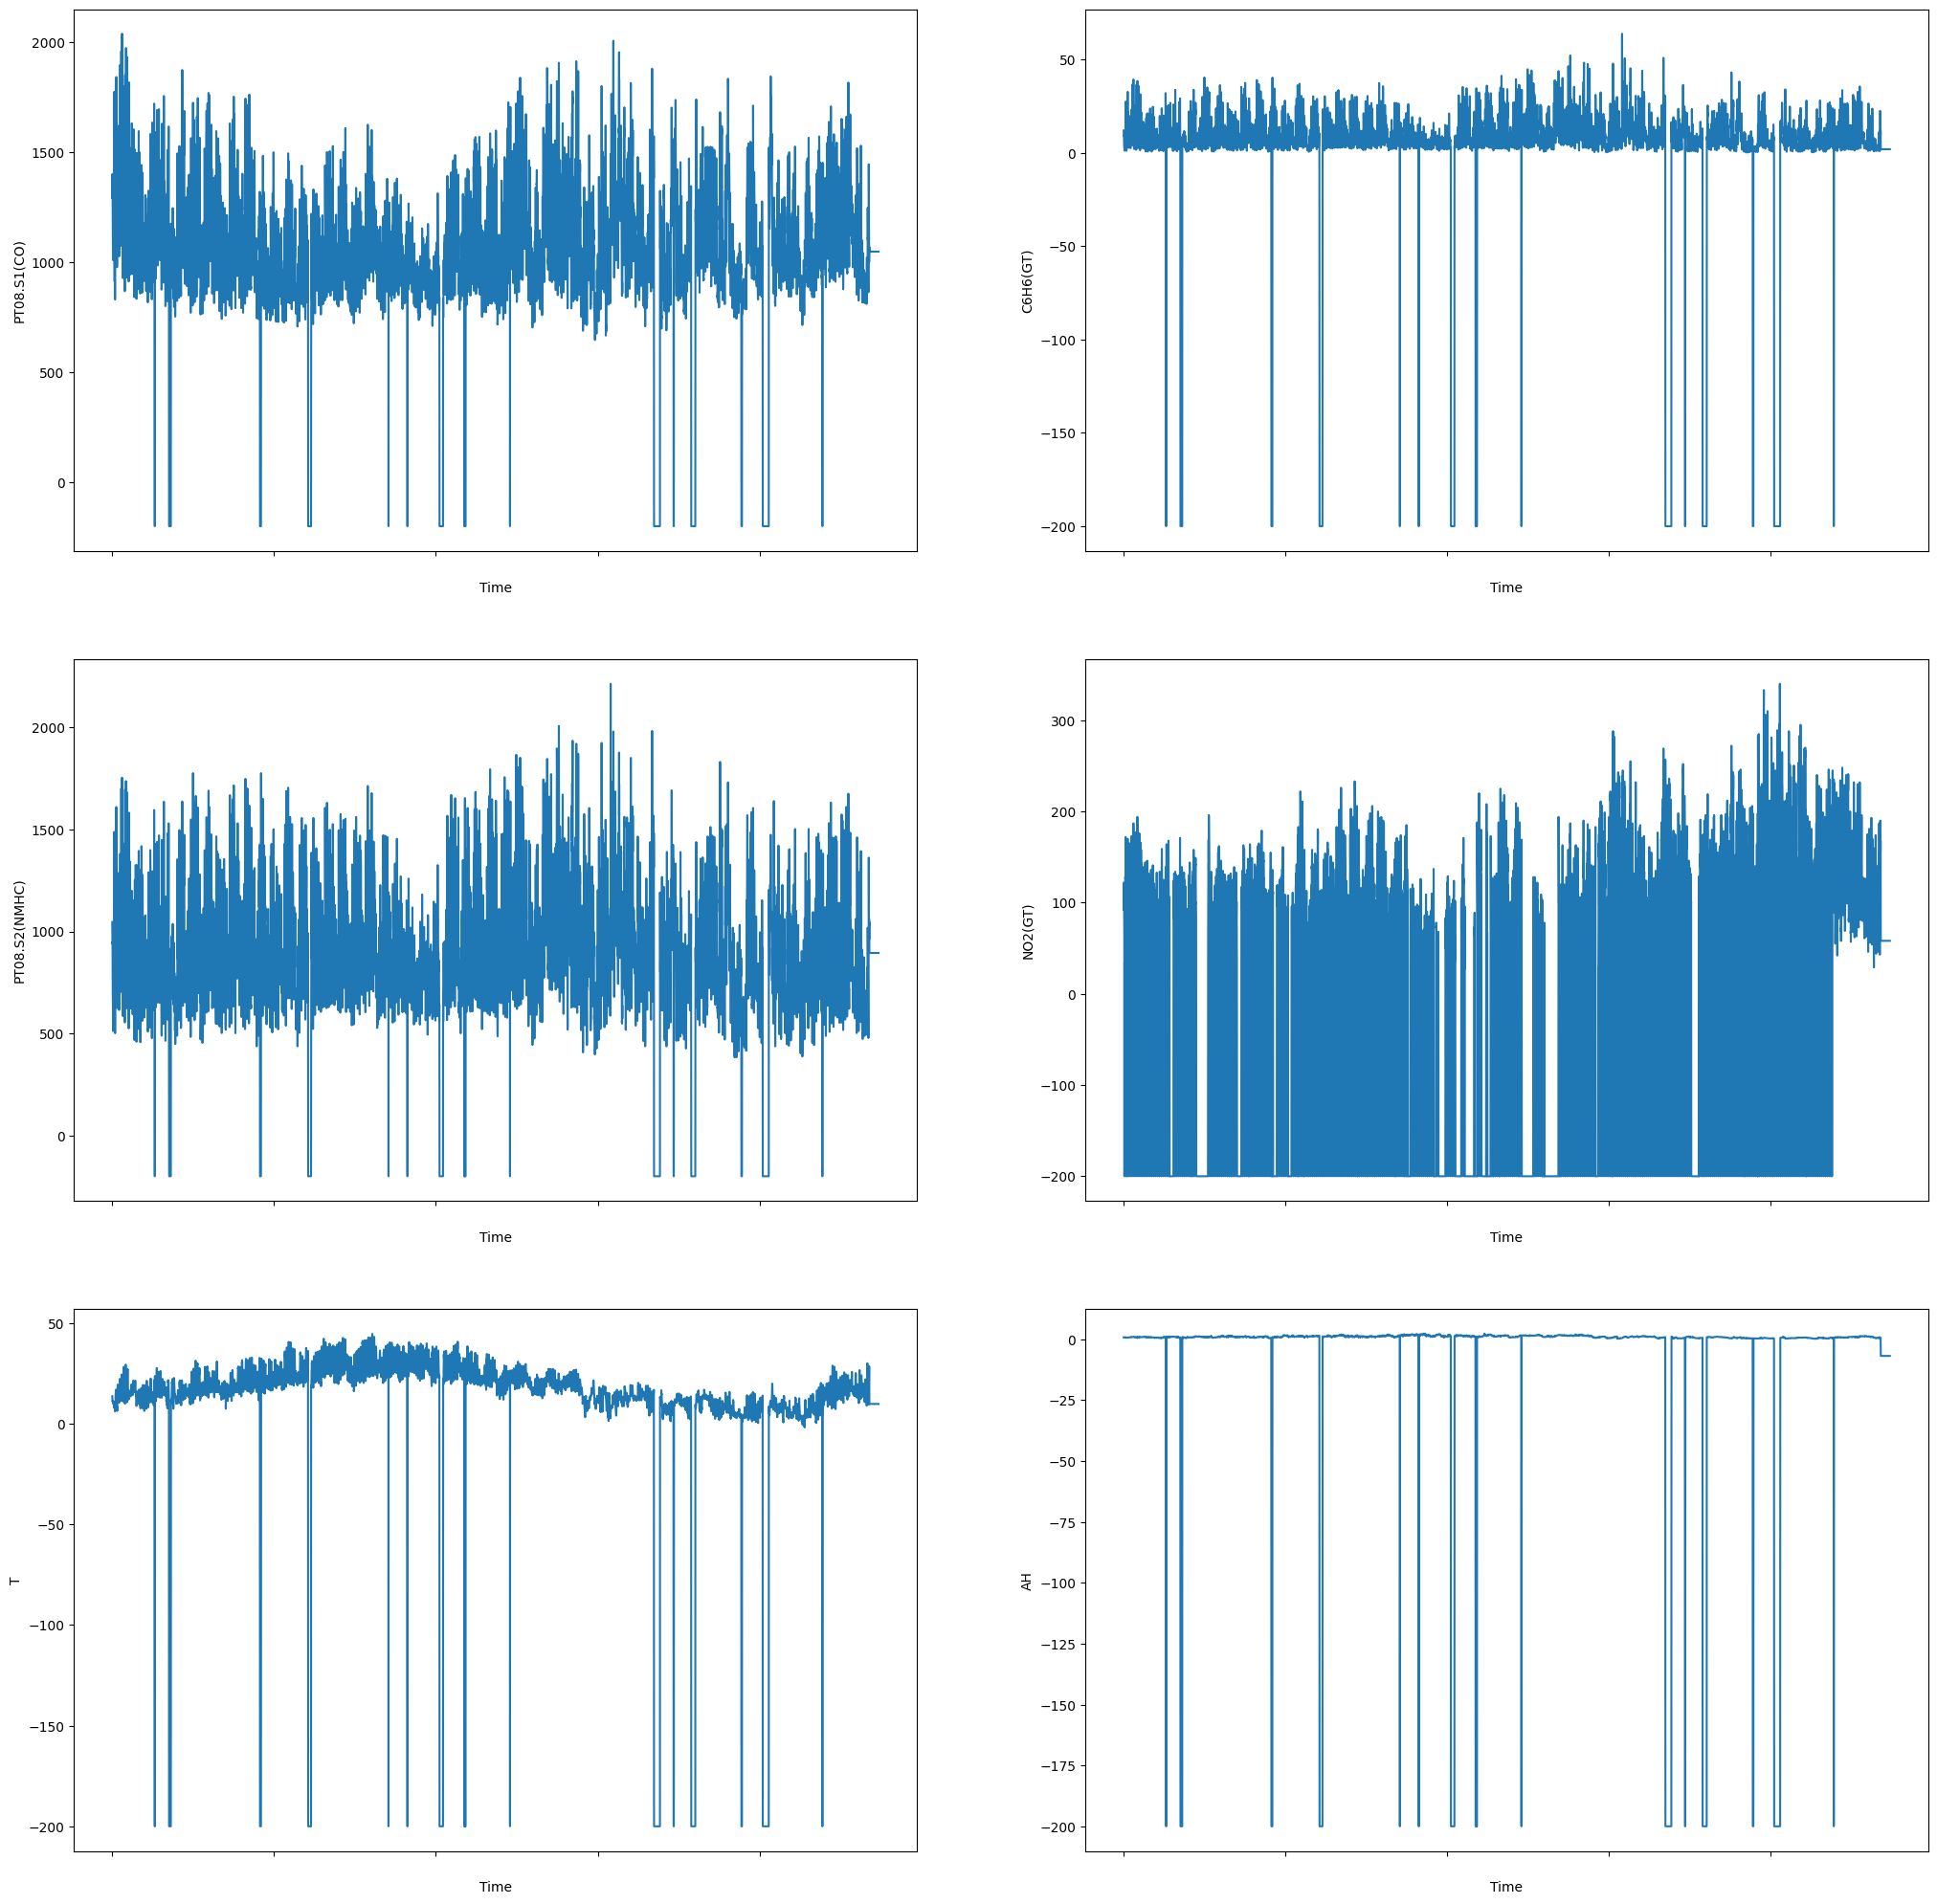

In [121]:
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(25,25))
row=column=0
for col in ['PT08.S1(CO)','C6H6(GT)', 'PT08.S2(NMHC)','NO2(GT)','T', 'AH']:
     if column not in [2,4]:
        axes[row][column].plot(data_p_object.data[col])
        axes[row][column].set_xticklabels([])
        axes[row][column].set_xlabel('\nTime')
        axes[row][column].set_ylabel(col)
        column+=1
     else:
        column=0
        row+=1
        axes[row][column].plot(data_p_object.data[col])
        axes[row][column].set_xticklabels([])
        axes[row][column].set_xlabel('\nTime')
        axes[row][column].set_ylabel(col)
        column+=1
fig.show()

#### DATA PREPROCESSING

##### INITIALIZING THE TARGET AND FEATURES

In [113]:
data_p_object.out_in('RH')

##### SPLITTING THE DATASET INTO TRAINING AND TESTING

In [114]:
data_p_object.split(0.2,rs=42)

##### NORMALIZING THE DATASET

In [115]:
data_p_object.standardize_or_normalize('Normalize')

#### MODEL FORMULATION

##### INITIALIZING THE CLASS OBJECT

In [128]:
model_obj = MachineLearningRegression(data_p_object)
review = model_obj.evaluvate()
review

{'LinearRegression': {'r2 score': 0.8946066140009717,
  'MAE': 14.988220371073911,
  'MSE': 278.63080613234837,
  'MAPE': 0.2675901992404197},
 'Ridge': {'r2 score': 0.9559351541546262,
  'MAE': 8.400647514884971,
  'MSE': 102.65677684775959,
  'MAPE': 0.17135250964618554},
 'Lasso': {'r2 score': 0.8196522798181968,
  'MAE': 14.739553003185407,
  'MSE': 309.9513462492309,
  'MAPE': 0.2910929528654701},
 'DecisionTreeRegressor': {'r2 score': 0.9971722237244639,
  'MAE': 2.073139841688655,
  'MSE': 6.698522427440634,
  'MAPE': 0.04507814143056146},
 'RandomForestRegressor': {'r2 score': 0.997577566422545,
  'MAE': 2.0004848265926487,
  'MSE': 5.734767810158643,
  'MAPE': 0.043089561032173485},
 'KNeighborsRegressor': {'r2 score': 0.960109281065825,
  'MAE': 7.399936675461742,
  'MSE': 94.90160337730872,
  'MAPE': 0.14924142336638327},
 'best model': {'Name': 'RandomForestRegressor',
  'r2 score': 0.997577566422545}}

##### FITTING THE MODEL AND EVALUVATING

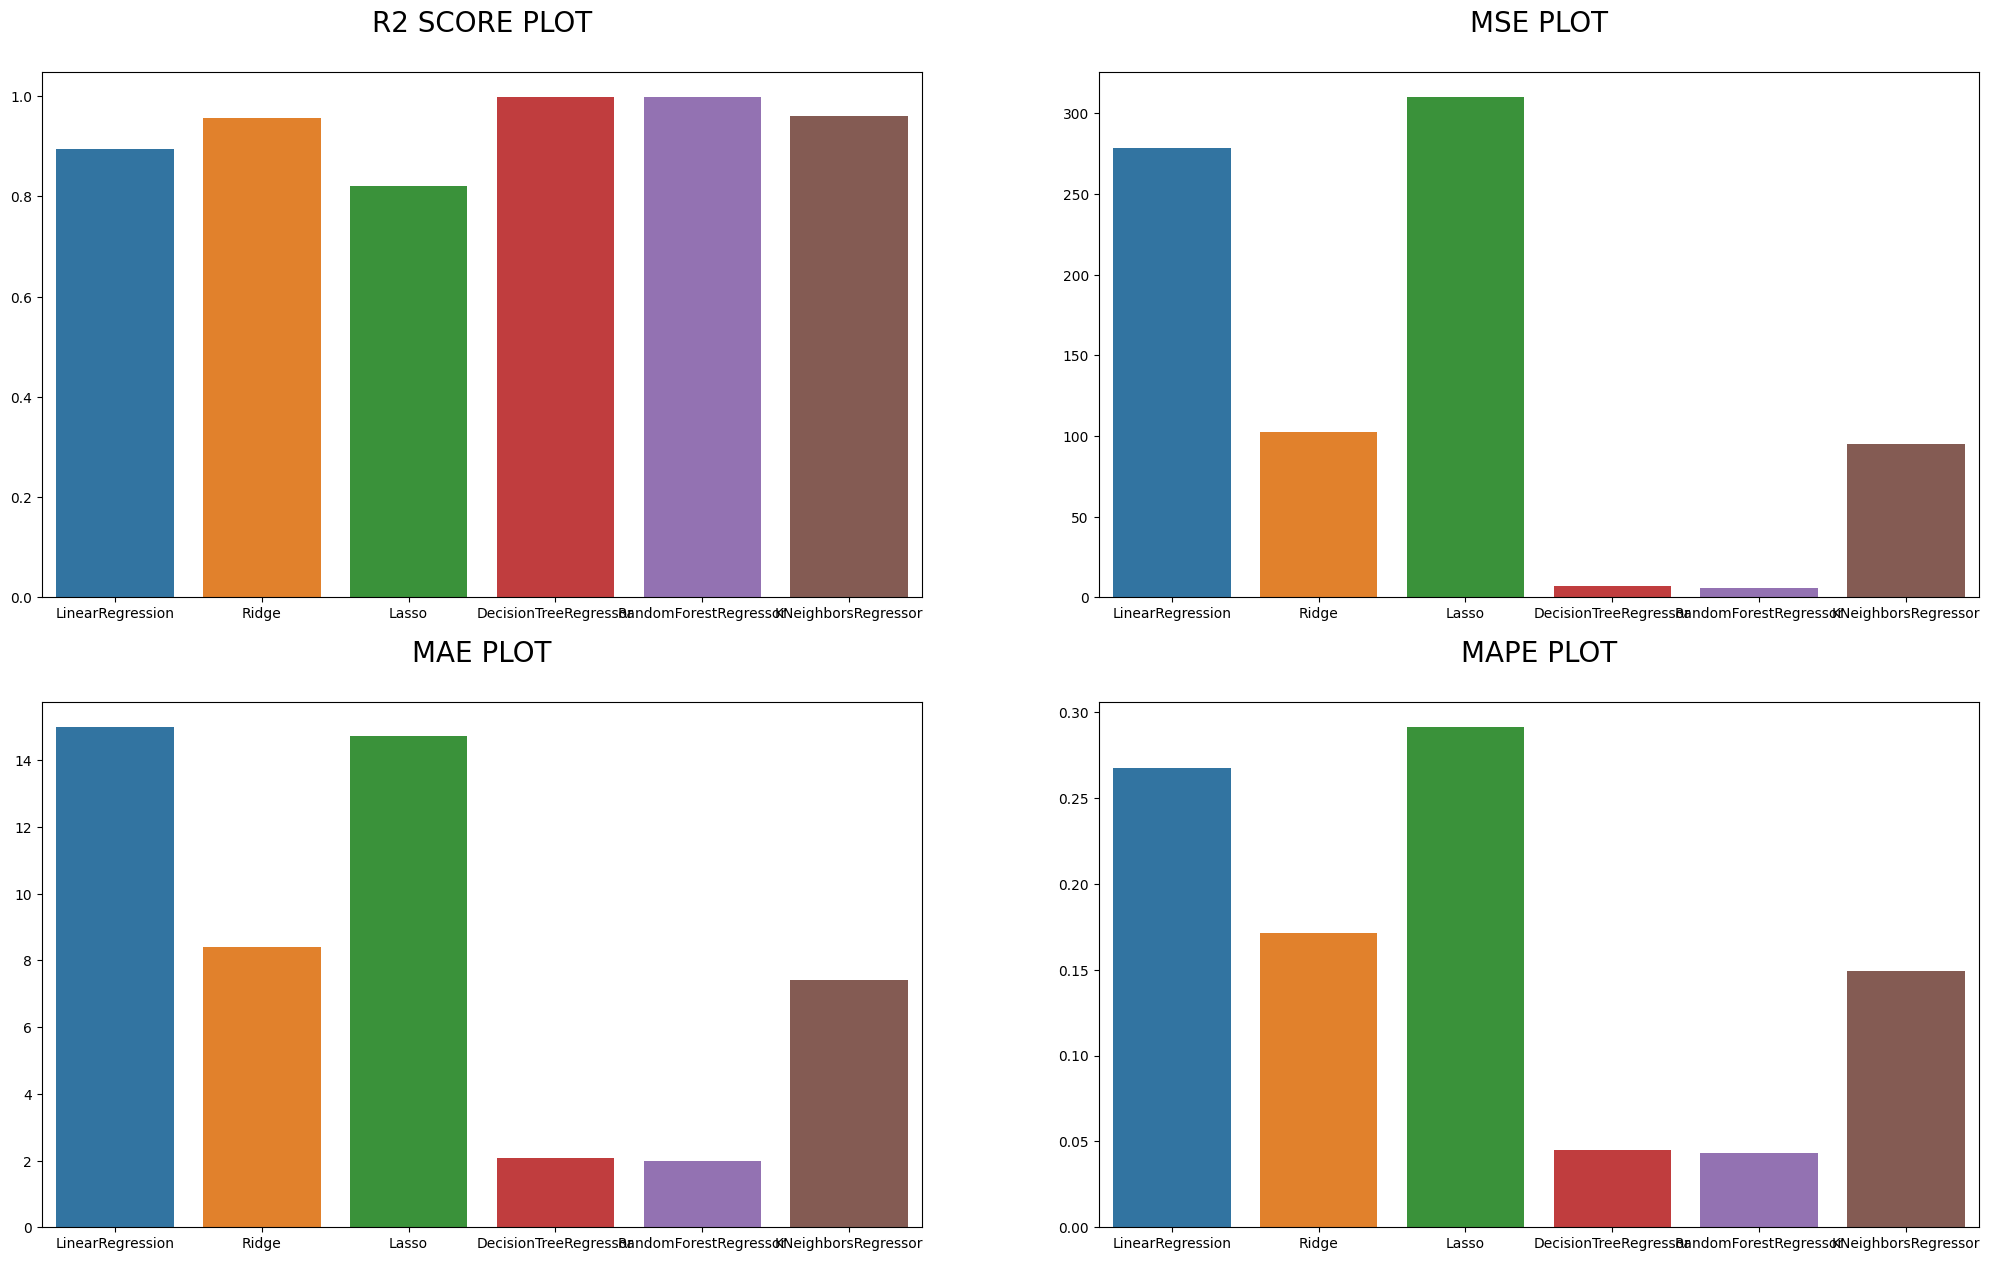

In [143]:
r2_score_list,MSE_list,MAE_list,MAPE_list={},{},{},{}
for model in review:
    if model!='best model':
        r2_score_list[model] = review[model]['r2 score']
        MSE_list[model] = review[model]['MSE']
        MAE_list[model] = review[model]['MAE']
        MAPE_list[model] = review[model]['MAPE']
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(25,15))
a = sns.barplot(x=list(r2_score_list.keys()),y=list(r2_score_list.values()),ax=axes[0][0])
a.set_title("R2 SCORE PLOT\n",fontsize=20)
b = sns.barplot(x=list(MSE_list.keys()),y=list(MSE_list.values()),ax=axes[0][1])
b.set_title("MSE PLOT\n",fontsize=20)
c = sns.barplot(x=list(MAE_list.keys()),y=list(MAE_list.values()),ax=axes[1][0])
c.set_title("MAE PLOT\n",fontsize=20)
d = sns.barplot(x=list(MAPE_list.keys()),y=list(MAPE_list.values()),ax=axes[1][1])
d.set_title("MAPE PLOT\n",fontsize=20)
fig.show()

## Dataset 2

### Breast cancer dataset from sklearn

#### READING THE DATASET

In [147]:
from sklearn.datasets import load_breast_cancer
dataset_2 = pd.DataFrame(data = load_breast_cancer().data,columns = load_breast_cancer().feature_names)
dataset_2['target'] = load_breast_cancer().target
dataset_p_obj_2 = DataPreprocessing(dataset_2)